## Physics-informed neural networks (PINNs) - PDE

In the following notebook we will showcase a formulation capable of approximating the solution of PDEs using PINNs.

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Example

We'll now consider the **Burgers' equation** and solve it using PINNs. The equation describes the dynamics of viscous fluids and can be expressed as:

$$
u_t + uu_x - \nu u_{xx} = 0
$$

Here, $ u(x, t) $ represents the velocity field of the fluid, $ \nu $ is the kinematic viscosity, and subscripts denote partial derivatives with respect to the corresponding variables.

We're particularly interested in solving the Burgers' equation under certain conditions. Let's assume a scenario where viscosity ($ \nu $) is small, leading to a phenomenon known as the **shock formation**. Mathematically, this is when:

$$
\nu \ll 1
$$

Additionally, let's specify the initial condition for the problem:

$$
u(x, t=0) = f(x)
$$

For this example, we'll consider a simple initial condition $ f(x) = \sin(\pi x) $.


Given the nature of fluid dynamics, it's common to impose boundary conditions. In this case, we'll assume **periodic boundary conditions** where the values at both ends of the domain $ x $ wrap around to each other. 
Mathematically, this can be expressed as:

$$
u(x=-1, t) = u(x=1, t) = 0
$$

The exact solution for this case is not readily available due to the nature of Burgers' equation. Hence, numerical methods like PINNs become particularly useful for approximating solutions in such scenarios.





$$
u_x(x, t=0) = 0
$$

These boundary and initial conditions, along with the Burgers' equation itself, form a well-defined initial-boundary value problem suitable for numerical solution using methods like PINNs.

In [2]:
### Neural Network ###

class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes):
        super().__init__()
        layers = []
        # Adding input layer to the first hidden layer
        layers.append(nn.Linear(in_features, hidden_layer_sizes[0]))
        layers.append(nn.Tanh())  # Tanh activation function for this type of network is used
        # Adding hidden layers
        for i in range(len(hidden_layer_sizes) - 1):
            layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
            layers.append(nn.Tanh())  
        # Adding output layer
        layers.append(nn.Linear(hidden_layer_sizes[-1], out_features))
        
        # Combining all layers into a Sequential module
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [3]:
class Net:
    def __init__(self):

        self.model = Model(
            in_features=2, 
            out_features=1, 
            hidden_layer_sizes=[20,20,20,20])
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # PDE
        # Here the matrix with the x and t coordinates is built
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        self.X.requires_grad = True
        
        # Boundary
        # Here the boundary conditions and initial conditions are set, the left hand-side
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic]).unsqueeze(1)
        

        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Boundary condition loss        
        y_pred = self.model(self.X_train)
        bc_loss = self.criterion(y_pred, self.y_train)

        # PDE loss
        u = self.model(self.X)
        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]
        
        loss_pde = torch.mean((du_dt + u.squeeze() * du_dx - 0.01 / math.pi * du_dxx)**2)
        
        # Total loss
        loss = loss_pde + bc_loss
        loss.backward()
        
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        
        self.iter = self.iter + 1
        return loss
    
    def train(self, epochs):
        self.model.train()
        for i in range(epochs):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

In [4]:
## Training##
net = Net()
net.train(1000)

c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.13816849887371063
200 0.08995131403207779
300 0.07394653558731079
400 0.060422517359256744
500 0.03527574986219406
600 0.02307911589741707
700 0.015951745212078094
800 0.013285895809531212
900 0.01165241003036499
1000 0.010446896776556969
1100 0.004249643534421921
1200 0.0015728457365185022
1300 0.0008953285287134349
1400 0.0004991558962501585
1500 0.0003672055609058589
1600 0.000280227221082896
1700 0.0002106645843014121
1800 0.00016258395044133067
1900 0.0001362192997476086
2000 0.0001147075672633946
2100 0.00010053086589323357
2200 8.971092756837606e-05
2300 7.669514161534607e-05
2400 6.436024705180898e-05
2500 5.5681630328763276e-05
2600 4.997461655875668e-05
2700 4.798431837116368e-05
2800 4.353477561380714e-05
2900 3.843251397483982e-05
3000 3.4815053368220106e-05
3100 3.180313797201961e-05
3200 2.9460534278769046e-05
3300 2.8820908482884988e-05
3400 2.5736688257893547e-05
3500 2.4187927920138463e-05
3600 2.28506833082065e-05
3700 2.102221333188936e-05
3800 2.01239745365455

In [5]:
## Evaluation ##

net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

In [6]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

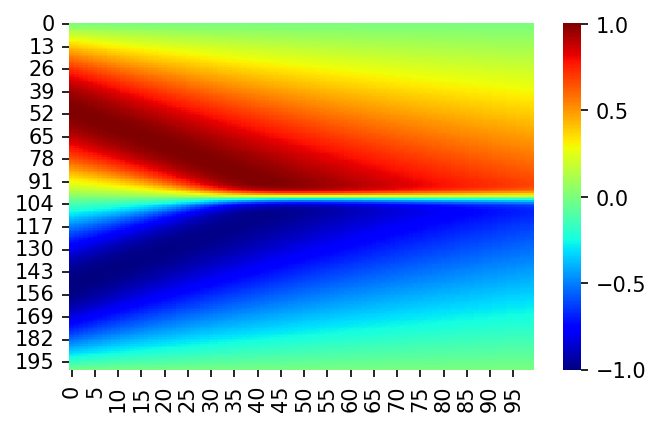

In [7]:
plt.figure(figsize=(5, 3), dpi=150)
sns.heatmap(y_pred, cmap='jet')
plt.show()